In [2]:

import os
import json
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.filters import threshold_otsu
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
from diffusers.models.attention import Attention
from huggingface_hub import login
from tqdm import tqdm
from collections import defaultdict, Counter
from itertools import chain

# === CONFIG ===
BASE_DIR = "../../"
MASK_DIR = os.path.join(BASE_DIR, "editing", "previous_mask")
OUTPUT_DIR = os.path.join(BASE_DIR, "attention_maps", "plots_iou")
IOU_RECORD_PATH = os.path.join(BASE_DIR, "attention_maps", "iou_scores_by_organ.json")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HF_TOKEN = "Your Huggingface API"
# DIFFUSION_STEPS = 50
DIFFUSION_STEPS = 25
# === INPUTS ===

model_id = "timbrooks/instruct-pix2pix"
model_name = "instruct-pix2pix"



# === ATTENTION LOGGING ===
ATTENTION_LOGS = {"cross": [], "self": []}
iou_store = defaultdict(lambda: defaultdict(list))
def make_patched_processor(base_cls):
    class PatchedProcessor(base_cls):
        def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, **kwargs):
            result = super().__call__(attn, hidden_states, encoder_hidden_states, attention_mask, **kwargs)
            q = attn.to_q(hidden_states)
            is_cross = encoder_hidden_states is not None
            k = attn.to_k(encoder_hidden_states if is_cross else hidden_states)
            bsz, seqlen, _ = q.shape
            num_heads = attn.heads
            head_dim = q.shape[-1] // num_heads
            scale = 1 / head_dim ** 0.5
            q = q.view(bsz, seqlen, num_heads, head_dim).transpose(1, 2)
            k = k.view(bsz, -1, num_heads, head_dim).transpose(1, 2)
            scores = torch.matmul(q, k.transpose(-2, -1)) * scale
            probs = torch.nn.functional.softmax(scores, dim=-1)
            attn_map = probs.mean(1).detach().cpu()
            if is_cross:
                ATTENTION_LOGS["cross"].append(attn_map)
            return result
    return PatchedProcessor

def patch_attention(pipe):
    for _, module in pipe.unet.named_modules():
        if isinstance(module, Attention):
            module.processor = make_patched_processor(type(module.processor))()

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0.0

# === LOAD PIPELINE ===
login(HF_TOKEN)
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if DEVICE.type == "cuda" else torch.float32,
    safety_checker=None
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
patch_attention(pipe)
pipe = pipe.to(DEVICE)

# === EXAMPLE MAPPING (should be customized) ===
task_to_concept = {
    "Remove wisdom teeth.": "teeth",
    "Remove stains, tartar, or plaque from teeth.": "teeth",
    "Implant or add missing teeth.": "teeth",
    "Repair or restore damaged teeth.": "teeth",
    "Add or remove braces.": "braces",
    "Reduce gaps between teeth.": "teeth",
    "Remove intestinal polyps or adenomas.": "polyps",
    "Remove rectal tumors.": "tumors",
    "Remove diseased intestine and stitch.": "intestine",
    "Replace infected appendix.": "appendix",
    "Remove anal warts.": "warts",
    "Reconstruct missing or injured eye.": "eye",
    "Reconstruct eyelid or lower eyelid skin.": "skin",
    "Create double eyelids.": "eyelids",
    "Remove eyelid styes (chalazion).": "chalazion",
    "Correct lower eyelid ectropion.": "ectropion",
    "Remove conjunctival nevus.": "nevus",
    "Remove eye bags.": "bags",
    "Remove eyelid xanthalasma.": "xanthalasma",
    "Match iris color between eyes.": "iris",
    "Remove visible eye blood vessels.": "vessels",
    "Repair or remove scar at eye corner.": "scar",
    "Improve eyelid folds and symmetry.": "folds",
    "Remove eyelid tumors or carcinoma.": "carcinoma",
    "Remove eye redness.": "redness",
    "Remove eyelid skin tags.": "eyelid",
    "Repair eyebrow arch skin.": "arch",
    "Tighten eyelids.": "eyelids",
    "Improve upper eyelid fullness.": "eyelid",
    "Match eye size and shape.": "eye",
    "Correct spine alignment.": "spine",
    "Fix fractures with screws or splints.": "fractures",
    "Simulate fractures in the arm.": "arm",
    "Replace joints or bones with prosthetics.": "bones",
    "Remove moles, nevi, or black marks.": "moles",
    "Reconstruct damaged skin or scalp.": "skin",
    "Remove varicose veins.": "veins",
    "Remove brown spots or pigmentation.": "pigmentation",
    "Remove or fade scars.": "scars",
    "Remove black birthmarks to even skin tone.": "birthmarks",
    "Remove bumps or cysts on the skin.": "skin",
    "Smoothen or improve skin texture.": "skin",
    "Reconstruct or repair nose skin.": "nose",
    "Remove or fade scar on nose.": "nose",
    "Remove or beautify rhinophyma.": "rhinophyma",
    "Remove redness on nose.": "nose",
    "Reduce facial wrinkles.": "wrinkles",
    "Remove or revise facial scars.": "scars",
    "Reconstruct cheek or forehead skin.": "skin",
    "Remove facial redness.": "redness",
    "Remove excess fat from neck.": "neck",
    "Lift neck and face by tightening skin.": "skin",
    "Remove facial acne, bumps, or cysts.": "cysts",
    "Remove facial veins.": "veins",
    "Correct facial asymmetry from nerve paralysis.": "facial",
    "Reconstruct ear.": "ear",
    "Reconstruct auricle.": "auricle",
    "Remove the scar left by the ear piercing.": "piercing",
    "Reconstruct earlobe.": "earlobe",
    "Complete missing finger or fingernail.": "fingernail",
    "Improve hand appearance by injectable filler.": "hand",
    "Remove brown spots on hand.": "hand",
    "Reconstruct damaged lip or lip skin.": "lip",
    "Perform lip augmentation.": "lip",
    "Perform body liposuction and skin tightening.": "liposuction",
    "Repair or reconstruct toenail.": "toenail",
    "Reconstruct missing toe.": "toe",
    "Make hair thicker.": "hair",
    "Make beard thicker.": "beard",
    "Make eyebrow thicker.": "eyebrow"
}

samples = json.load(open(os.path.join(BASE_DIR, "editing", "editing_metadata.json")))["samples"]
os.makedirs(OUTPUT_DIR, exist_ok=True)    
# === MAIN LOOP ===

for task, visual_concept in task_to_concept.items():
    matching_samples = [s for s in samples if s["Task"] == task]
    organ = matching_samples[0]['Organ']
    for sample in matching_samples:
        img_id = sample["id"]
        img_path = os.path.join(BASE_DIR, "editing", "previous", f"{img_id}.png")  # Adjust if different
        # === IMAGE ===
        original_image = Image.open(img_path).convert("RGB")
        width, height = original_image.size
        # === RUN MODEL ===
        result = pipe(
            task,
            image=original_image.resize((512, 512)),
            num_inference_steps=DIFFUSION_STEPS,
            image_guidance_scale=1.6,
            guidance_scale=7.5,
            generator=torch.manual_seed(0)
        )
        edited_image = result.images[0].resize((width, height))

        # === LOCATE TOKEN ===
        tokens = pipe.tokenizer(task, return_tensors="pt")["input_ids"][0]
        concept_token = pipe.tokenizer(visual_concept, return_tensors="pt")["input_ids"][0][-2]
        last_token_idx = tokens.tolist().index(concept_token)
        decoded = pipe.tokenizer.convert_ids_to_tokens(tokens)

        # === EXTRACT ATTENTION ===
        maps = []
        for attn in ATTENTION_LOGS["cross"]:
            token_map = attn[0, :, last_token_idx]
            Q = token_map.shape[0]
            H = W = int(Q ** 0.5)
            while H * W != Q and H > 1:
                H -= 1
                W = Q // H if Q % H == 0 else W
            if H * W != Q:
                continue
            heat = token_map.view(1, 1, H, W)
            heat = F.interpolate(heat, size=(height, width), mode="bilinear", align_corners=False)
            maps.append(heat)

        if maps:
            avg_map = torch.stack(maps).mean(dim=0)[0, 0]
            avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min())
            threshold = threshold_otsu(avg_map.numpy()) * 1.3
            binary_mask = (avg_map.numpy() > threshold).astype(np.uint8)

            # === GROUND TRUTH ===
            mask_path = os.path.join(MASK_DIR, f"{img_id}.png")
            gt_mask = Image.open(mask_path).convert("L").resize((width, height))
            gt_mask_np = np.array(gt_mask) > 127

            iou = compute_iou(binary_mask, gt_mask_np)
            iou_store[organ][task].append(iou)

            # === PLOT ===
            fig, axs = plt.subplots(1, 5, figsize=(24, 5))
            axs[0].imshow(original_image)
            axs[0].set_title("Previous Image")
            axs[1].imshow(edited_image)
            axs[1].set_title("Edited Image")
            axs[2].imshow(avg_map.numpy(), cmap="magma")
            axs[2].set_title("Attention Map")
            axs[3].imshow(binary_mask, cmap="gray")
            axs[3].set_title("Thresholded Mask")
            axs[4].imshow(gt_mask_np, cmap="gray")
            axs[4].set_title("Ground Truth Mask")
            for ax in axs: ax.axis("off")
            plt.suptitle(f"{task} | {decoded[last_token_idx]}  | ID {img_id} | IoU: {iou:.4f}")
            plt.tight_layout()
            plot_path = os.path.join(OUTPUT_DIR, f"{organ.replace(' ', '_')}_{task[:30].replace(' ', '_')}_{img_id}.png")
            plt.savefig(plot_path)
            plt.close()
            # plt.show()
        else:
            print("No valid attention maps found.")
        ATTENTION_LOGS["cross"].clear()
        ATTENTION_LOGS["self"].clear()
        
# === SAVE IOU JSON ===
avg_iou_by_organ = {
    organ: round(
        sum(iou for task_list in tasks.values() for iou in task_list) /
        sum(len(task_list) for task_list in tasks.values()), 4
    )
    for organ, tasks in iou_store.items()
}
final_iou_record = {
    "iou_by_organ_and_task": iou_store,
    "average_iou_by_organ": avg_iou_by_organ
}
with open(IOU_RECORD_PATH, "w") as f:
    json.dump(final_iou_record, f, indent=2)


100%|██████████| 25/25 [00:13<00:00,  1.92it/s]


In [2]:
import json
from statistics import mean

# Load the original JSON file
with open("../attention_maps/iou_scores_by_organ.json", "r") as f:
    data = json.load(f)

# Compute average IOU scores
average_scores = {}

for organ, tasks in data["iou_by_organ_and_task"].items():
    average_scores[organ] = {}
    for task, scores in tasks.items():
        average_scores[organ][task] = round(mean(scores), 2)

# Append the averages under a new key
data["average_iou_by_task"] = average_scores

# Save the modified JSON back to the original file
with open("../attention_maps/iou_scores_by_organ.json", "w") as f:
    json.dump(data, f, indent=2)

print("Averages appended to iou_scores_by_organ.json under 'average_iou_by_organ_and_task'")


Averages appended to iou_scores_by_organ.json under 'average_iou_by_organ_and_task'


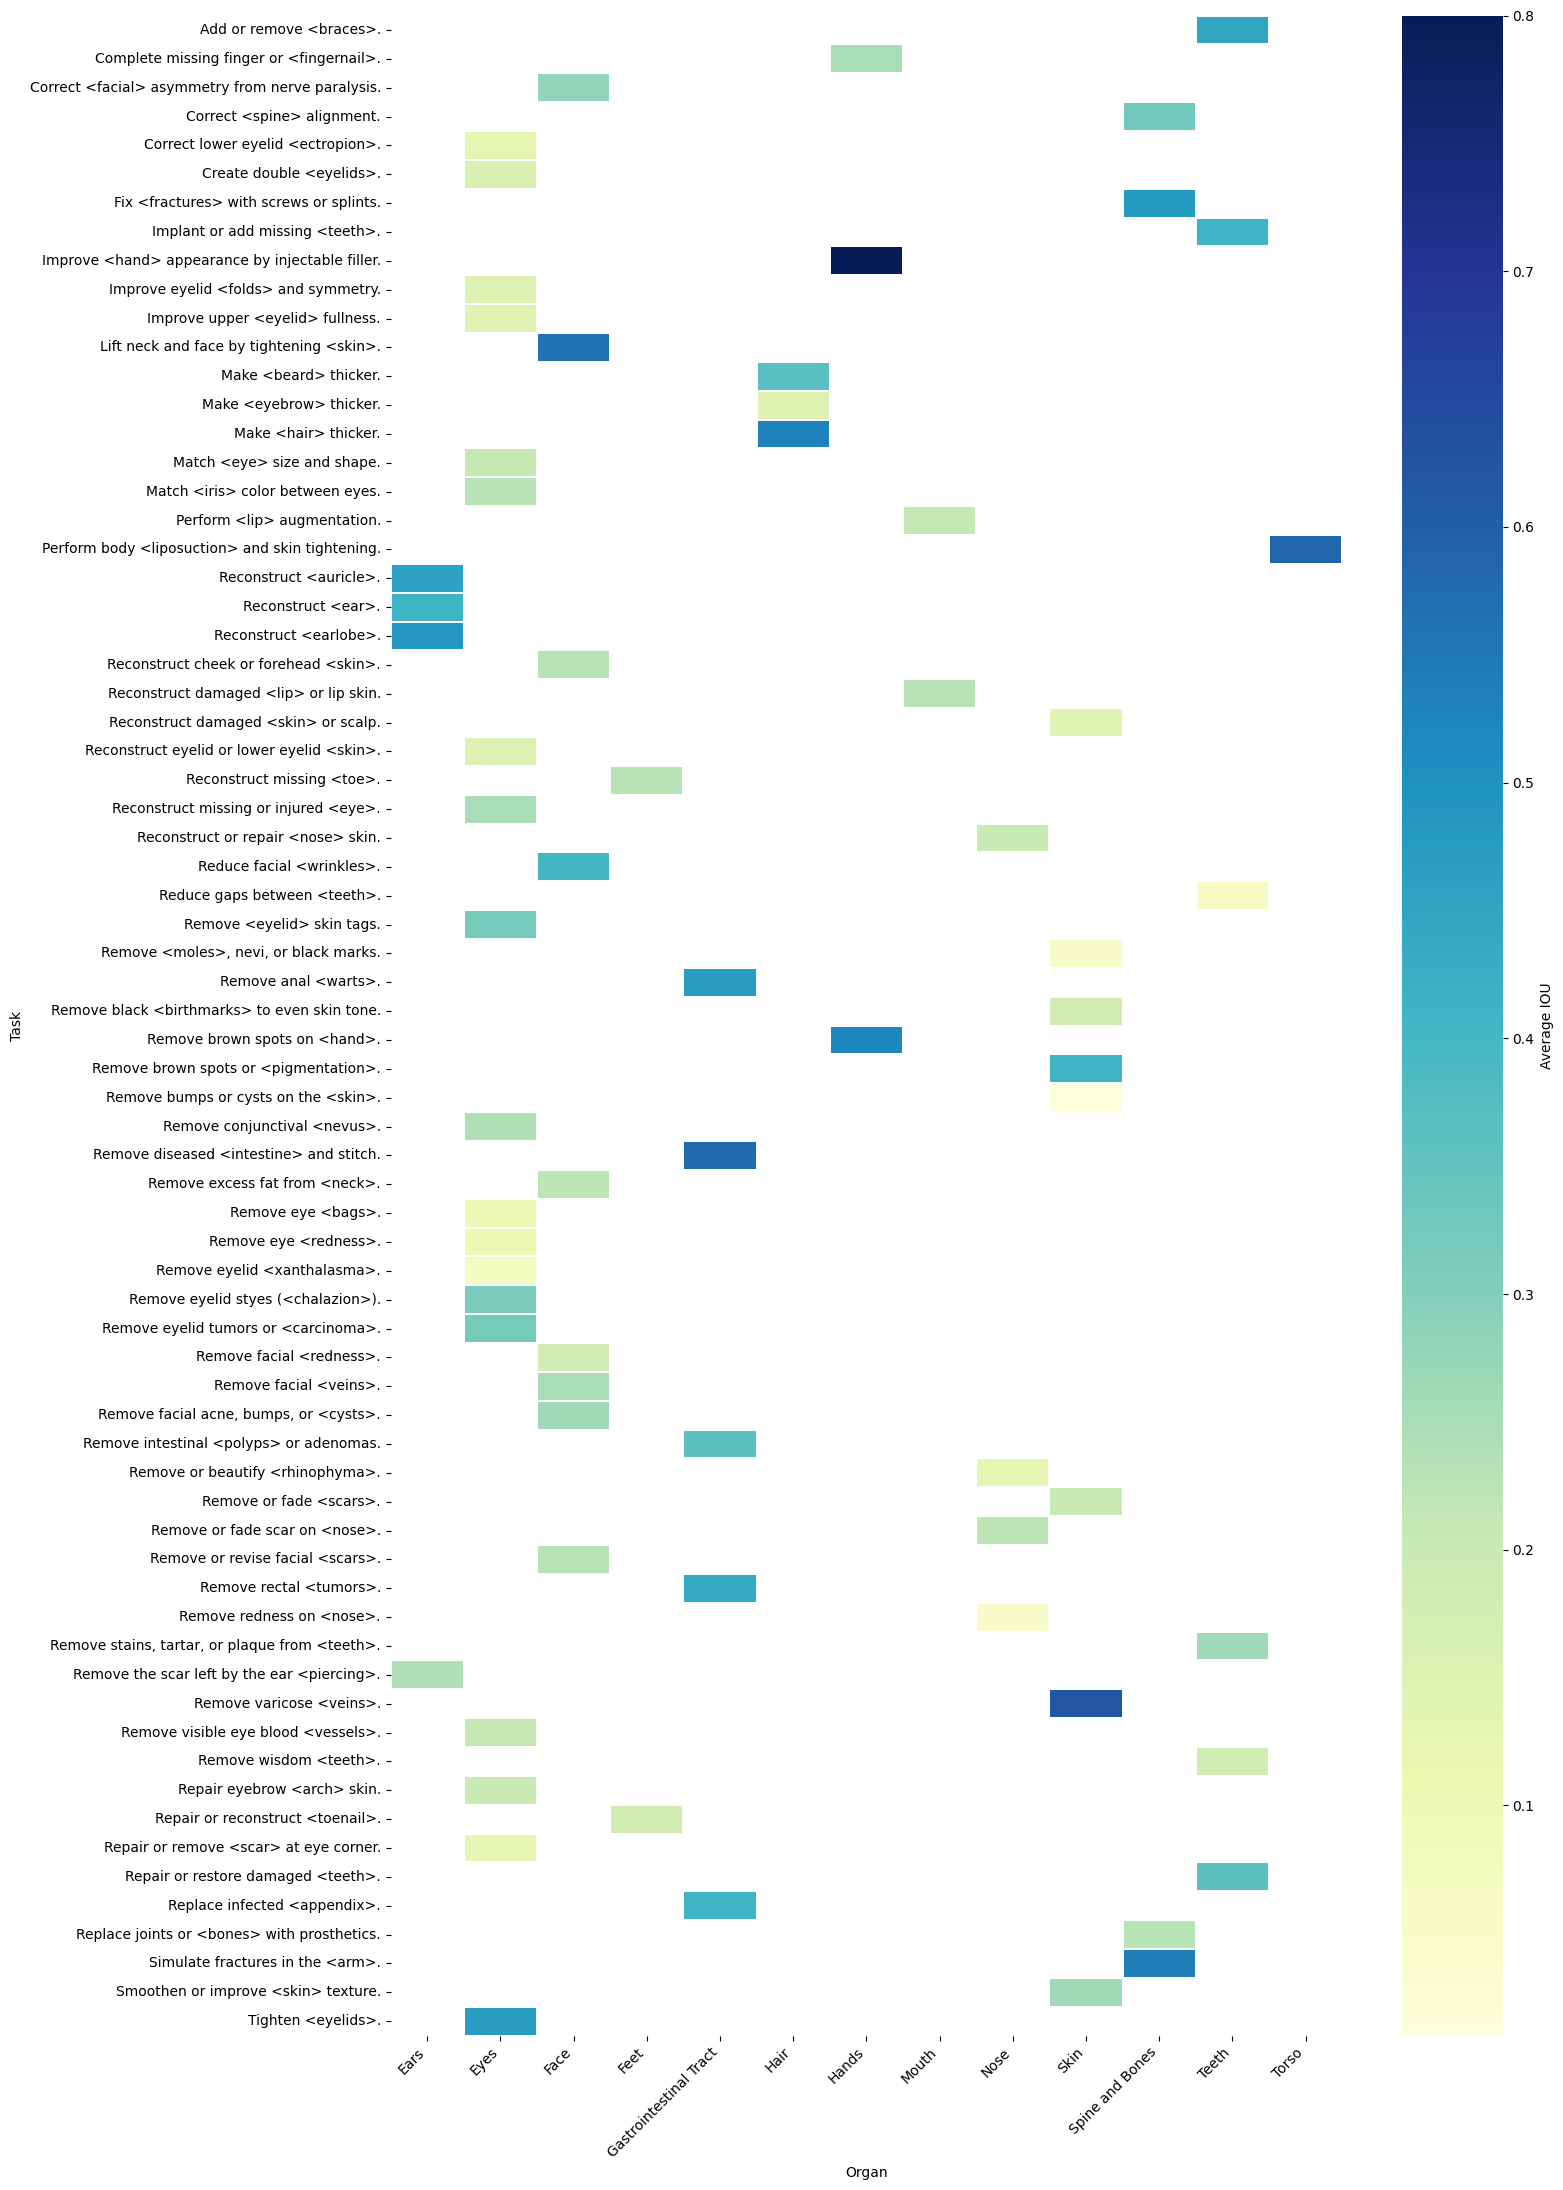

In [9]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load JSON data
with open("../attention_maps/iou_scores_by_organ.json", "r") as f:
    data = json.load(f)

# Extract average IOU by task
avg_iou_by_task = data["average_iou_by_task"]

# Task-to-concept mapping
task_to_concept = {
    "Remove wisdom teeth.": "teeth",
    "Remove stains, tartar, or plaque from teeth.": "teeth",
    "Implant or add missing teeth.": "teeth",
    "Repair or restore damaged teeth.": "teeth",
    "Add or remove braces.": "braces",
    "Reduce gaps between teeth.": "teeth",
    "Remove intestinal polyps or adenomas.": "polyps",
    "Remove rectal tumors.": "tumors",
    "Remove diseased intestine and stitch.": "intestine",
    "Replace infected appendix.": "appendix",
    "Remove anal warts.": "warts",
    "Reconstruct missing or injured eye.": "eye",
    "Reconstruct eyelid or lower eyelid skin.": "skin",
    "Create double eyelids.": "eyelids",
    "Remove eyelid styes (chalazion).": "chalazion",
    "Correct lower eyelid ectropion.": "ectropion",
    "Remove conjunctival nevus.": "nevus",
    "Remove eye bags.": "bags",
    "Remove eyelid xanthalasma.": "xanthalasma",
    "Match iris color between eyes.": "iris",
    "Remove visible eye blood vessels.": "vessels",
    "Repair or remove scar at eye corner.": "scar",
    "Improve eyelid folds and symmetry.": "folds",
    "Remove eyelid tumors or carcinoma.": "carcinoma",
    "Remove eye redness.": "redness",
    "Remove eyelid skin tags.": "eyelid",
    "Repair eyebrow arch skin.": "arch",
    "Tighten eyelids.": "eyelids",
    "Improve upper eyelid fullness.": "eyelid",
    "Match eye size and shape.": "eye",
    "Correct spine alignment.": "spine",
    "Fix fractures with screws or splints.": "fractures",
    "Simulate fractures in the arm.": "arm",
    "Replace joints or bones with prosthetics.": "bones",
    "Remove moles, nevi, or black marks.": "moles",
    "Reconstruct damaged skin or scalp.": "skin",
    "Remove varicose veins.": "veins",
    "Remove brown spots or pigmentation.": "pigmentation",
    "Remove or fade scars.": "scars",
    "Remove black birthmarks to even skin tone.": "birthmarks",
    "Remove bumps or cysts on the skin.": "skin",
    "Smoothen or improve skin texture.": "skin",
    "Reconstruct or repair nose skin.": "nose",
    "Remove or fade scar on nose.": "nose",
    "Remove or beautify rhinophyma.": "rhinophyma",
    "Remove redness on nose.": "nose",
    "Reduce facial wrinkles.": "wrinkles",
    "Remove or revise facial scars.": "scars",
    "Reconstruct cheek or forehead skin.": "skin",
    "Remove facial redness.": "redness",
    "Remove excess fat from neck.": "neck",
    "Lift neck and face by tightening skin.": "skin",
    "Remove facial acne, bumps, or cysts.": "cysts",
    "Remove facial veins.": "veins",
    "Correct facial asymmetry from nerve paralysis.": "facial",
    "Reconstruct ear.": "ear",
    "Reconstruct auricle.": "auricle",
    "Remove the scar left by the ear piercing.": "piercing",
    "Reconstruct earlobe.": "earlobe",
    "Complete missing finger or fingernail.": "fingernail",
    "Improve hand appearance by injectable filler.": "hand",
    "Remove brown spots on hand.": "hand",
    "Reconstruct damaged lip or lip skin.": "lip",
    "Perform lip augmentation.": "lip",
    "Perform body liposuction and skin tightening.": "liposuction",
    "Repair or reconstruct toenail.": "toenail",
    "Reconstruct missing toe.": "toe",
    "Make hair thicker.": "hair",
    "Make beard thicker.": "beard",
    "Make eyebrow thicker.": "eyebrow"
}

# Flatten the dictionary into a DataFrame
rows = []
for organ, tasks in avg_iou_by_task.items():
    for task, score in tasks.items():
        concept = task_to_concept.get(task, "")
        if concept and concept.lower() in task.lower():
            idx = task.lower().find(concept.lower())
            task_with_highlight = (
                task[:idx] + "<" + task[idx:idx+len(concept)] + ">" + task[idx+len(concept):]
            )
        else:
            task_with_highlight = task
        rows.append({"Organ": organ, "Task": task_with_highlight, "IOU": score})

df = pd.DataFrame(rows)

# Pivot for heatmap
pivot_df = df.pivot(index="Task", columns="Organ", values="IOU")

# Plot
plt.figure(figsize=(16, 22))
ax = sns.heatmap(pivot_df, cmap="YlGnBu", annot=False, linewidths=0.3, cbar_kws={'label': 'Average IOU'})
# plt.title("Average IOU per Task Across Organs (Concepts in <>)", fontsize=16)
plt.xlabel("Organ")
plt.ylabel("Task")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


Image ID: 875
Task: Repair or reconstruct toenail.
IoU Score: 0.1692


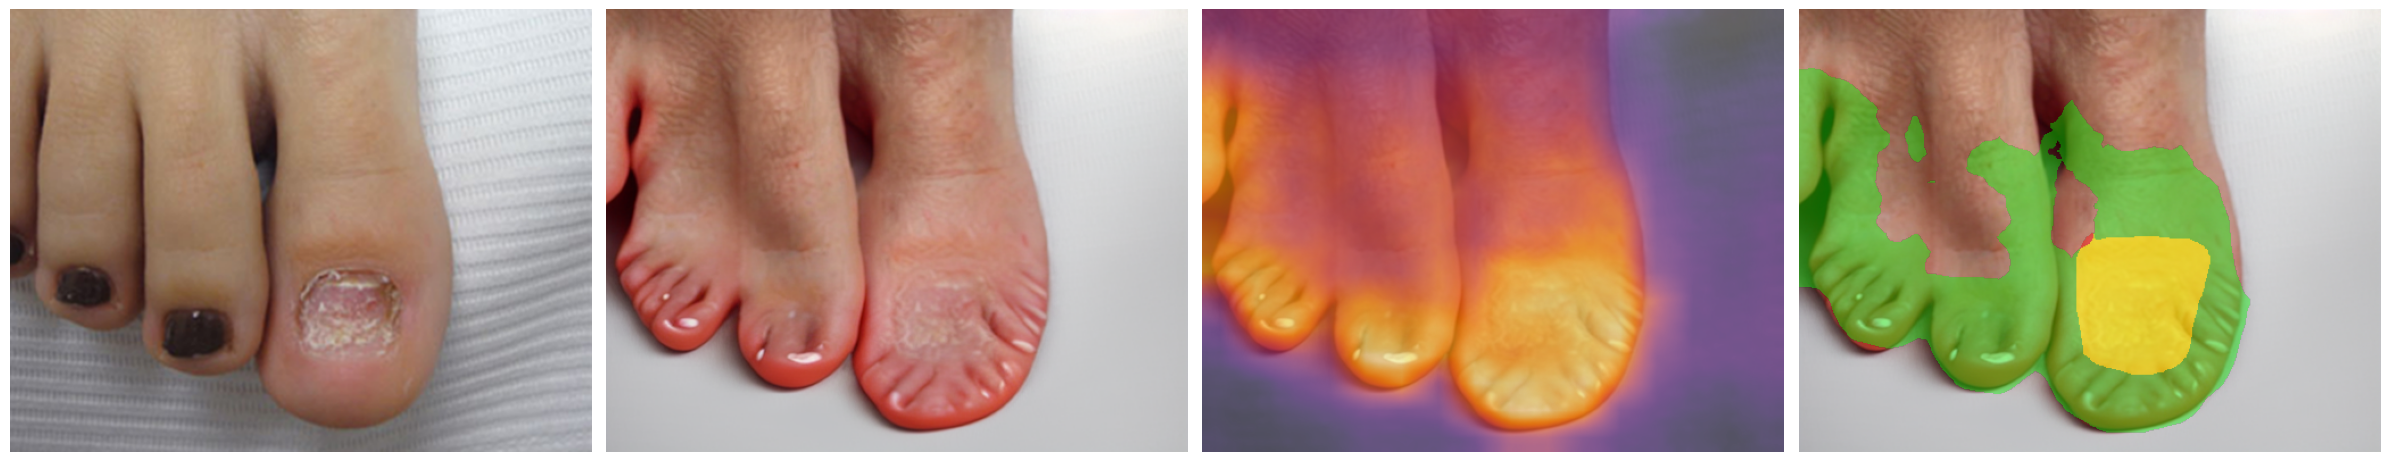

In [2]:
import os
import json
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.filters import threshold_otsu
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
from diffusers.models.attention import Attention
from huggingface_hub import login

task_to_concept = {
    "Remove wisdom teeth.": "teeth",
    "Remove stains, tartar, or plaque from teeth.": "teeth",
    "Implant or add missing teeth.": "teeth",
    "Repair or restore damaged teeth.": "teeth",
    "Add or remove braces.": "braces",
    "Reduce gaps between teeth.": "teeth",
    "Remove intestinal polyps or adenomas.": "polyps",
    "Remove rectal tumors.": "tumors",
    "Remove diseased intestine and stitch.": "intestine",
    "Replace infected appendix.": "appendix",
    "Remove anal warts.": "warts",
    "Reconstruct missing or injured eye.": "eye",
    "Reconstruct eyelid or lower eyelid skin.": "skin",
    "Create double eyelids.": "eyelids",
    "Remove eyelid styes (chalazion).": "chalazion",
    "Correct lower eyelid ectropion.": "ectropion",
    "Remove conjunctival nevus.": "nevus",
    "Remove eye bags.": "bags",
    "Remove eyelid xanthalasma.": "xanthalasma",
    "Match iris color between eyes.": "iris",
    "Remove visible eye blood vessels.": "vessels",
    "Repair or remove scar at eye corner.": "scar",
    "Improve eyelid folds and symmetry.": "folds",
    "Remove eyelid tumors or carcinoma.": "carcinoma",
    "Remove eye redness.": "redness",
    "Remove eyelid skin tags.": "eyelid",
    "Repair eyebrow arch skin.": "arch",
    "Tighten eyelids.": "eyelids",
    "Improve upper eyelid fullness.": "eyelid",
    "Match eye size and shape.": "eye",
    "Correct spine alignment.": "spine",
    "Fix fractures with screws or splints.": "fractures",
    "Simulate fractures in the arm.": "arm",
    "Replace joints or bones with prosthetics.": "bones",
    "Remove moles, nevi, or black marks.": "moles",
    "Reconstruct damaged skin or scalp.": "skin",
    "Remove varicose veins.": "veins",
    "Remove brown spots or pigmentation.": "pigmentation",
    "Remove or fade scars.": "scars",
    "Remove black birthmarks to even skin tone.": "birthmarks",
    "Remove bumps or cysts on the skin.": "skin",
    "Smoothen or improve skin texture.": "skin",
    "Reconstruct or repair nose skin.": "nose",
    "Remove or fade scar on nose.": "nose",
    "Remove or beautify rhinophyma.": "rhinophyma",
    "Remove redness on nose.": "nose",
    "Reduce facial wrinkles.": "wrinkles",
    "Remove or revise facial scars.": "scars",
    "Reconstruct cheek or forehead skin.": "skin",
    "Remove facial redness.": "redness",
    "Remove excess fat from neck.": "neck",
    "Lift neck and face by tightening skin.": "skin",
    "Remove facial acne, bumps, or cysts.": "cysts",
    "Remove facial veins.": "veins",
    "Correct facial asymmetry from nerve paralysis.": "facial",
    "Reconstruct ear.": "ear",
    "Reconstruct auricle.": "auricle",
    "Remove the scar left by the ear piercing.": "piercing",
    "Reconstruct earlobe.": "earlobe",
    "Complete missing finger or fingernail.": "fingernail",
    "Improve hand appearance by injectable filler.": "hand",
    "Remove brown spots on hand.": "hand",
    "Reconstruct damaged lip or lip skin.": "lip",
    "Perform lip augmentation.": "lip",
    "Perform body liposuction and skin tightening.": "liposuction",
    "Repair or reconstruct toenail.": "toenail",
    "Reconstruct missing toe.": "toe",
    "Make hair thicker.": "hair",
    "Make beard thicker.": "beard",
    "Make eyebrow thicker.": "eyebrow"
}
# === CONFIG ===
BASE_DIR = "../../MedGen"
MASK_DIR = os.path.join(BASE_DIR, "editing", "previous_mask")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HF_TOKEN = "Your Huggingface Token"
DIFFUSION_STEPS = 25


# === ATTENTION LOGGING ===
ATTENTION_LOGS = {"cross": [], "self": []}
def make_patched_processor(base_cls):
    class PatchedProcessor(base_cls):
        def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, **kwargs):
            result = super().__call__(attn, hidden_states, encoder_hidden_states, attention_mask, **kwargs)
            q = attn.to_q(hidden_states)
            is_cross = encoder_hidden_states is not None
            k = attn.to_k(encoder_hidden_states if is_cross else hidden_states)
            bsz, seqlen, _ = q.shape
            num_heads = attn.heads
            head_dim = q.shape[-1] // num_heads
            scale = 1 / head_dim ** 0.5
            q = q.view(bsz, seqlen, num_heads, head_dim).transpose(1, 2)
            k = k.view(bsz, -1, num_heads, head_dim).transpose(1, 2)
            scores = torch.matmul(q, k.transpose(-2, -1)) * scale
            probs = torch.nn.functional.softmax(scores, dim=-1)
            attn_map = probs.mean(1).detach().cpu()
            if is_cross:
                ATTENTION_LOGS["cross"].append(attn_map)
            return result
    return PatchedProcessor

def patch_attention(pipe):
    for _, module in pipe.unet.named_modules():
        if isinstance(module, Attention):
            module.processor = make_patched_processor(type(module.processor))()

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0.0

# === LOAD PIPELINE ===
login(HF_TOKEN)
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    torch_dtype=torch.float16 if DEVICE.type == "cuda" else torch.float32,
    safety_checker=None
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
patch_attention(pipe)
pipe = pipe.to(DEVICE)



TARGET_IDs = [875, 756, 972, 832, 512, 585, 52, 53, 1024, 930, 761, 161, 82, 7, 994, 13, 958]
for TARGET_ID in TARGET_IDs[:1]:


    # === LOAD SAMPLE ===
    samples = json.load(open(os.path.join(BASE_DIR, "editing", "editing_metadata.json")))["samples"]
    sample = next(s for s in samples if s["id"] == TARGET_ID)
    task = sample["Task"]
    visual_concept = task_to_concept[task]  # Fallback heuristic

    img_path = os.path.join(BASE_DIR, "editing", "previous", f"{TARGET_ID}.png")
    gt_path = os.path.join(BASE_DIR, "editing", "changed", f"{TARGET_ID}.png")
    mask_path = os.path.join(MASK_DIR, f"{TARGET_ID}.png")
    original_image = Image.open(img_path).convert("RGB")
    gt_image = Image.open(gt_path).convert("RGB")
    width, height = original_image.size

    # === RUN MODEL ===
    ATTENTION_LOGS["cross"].clear()
    result = pipe(
        task,
        image=original_image.resize((512, 512)),
        num_inference_steps=DIFFUSION_STEPS,
        image_guidance_scale=1.6,
        guidance_scale=7.5,
        generator=torch.manual_seed(0)
    )
    edited_image = result.images[0].resize((width, height))

    # === LOCATE TOKEN ===
    tokens = pipe.tokenizer(task, return_tensors="pt")["input_ids"][0]
    concept_token = pipe.tokenizer(visual_concept, return_tensors="pt")["input_ids"][0][-2]
    last_token_idx = tokens.tolist().index(concept_token)

    # === EXTRACT ATTENTION ===
    maps = []
    for attn in ATTENTION_LOGS["cross"]:
        token_map = attn[0, :, last_token_idx]
        Q = token_map.shape[0]
        H = W = int(Q ** 0.5)
        while H * W != Q and H > 1:
            H -= 1
            W = Q // H if Q % H == 0 else W
        if H * W != Q:
            continue
        heat = token_map.view(1, 1, H, W)
        heat = F.interpolate(heat, size=(height, width), mode="bilinear", align_corners=False)
        maps.append(heat)

    if not maps:
        print("No valid attention maps found.")
    else:
    # === Compute IoU & Prepare Masks ===
        avg_map = torch.stack(maps).mean(dim=0)[0, 0]
        avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min())
        threshold = threshold_otsu(avg_map.numpy()) * 1.3
        binary_mask = (avg_map.numpy() > threshold).astype(np.uint8)

        gt_mask = Image.open(mask_path).convert("L").resize((width, height))
        gt_mask_np = np.array(gt_mask) > 127
        iou = compute_iou(binary_mask, gt_mask_np)

        print(f"Image ID: {TARGET_ID}")
        print(f"Task: {task}")
        print(f"IoU Score: {iou:.4f}")

        # === Visualization (4 Panels) ===
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))

        # 1. Previous Image
        axs[0].imshow(original_image)
        # axs[0].set_title("Previous Image")
        axs[0].axis("off")

        # 2. Edited Image
        axs[1].imshow(edited_image)
        # axs[1].set_title("Edited Image")
        axs[1].axis("off")

        # 3. Edited + Attention Map
        attention_vis = avg_map.numpy()
        axs[2].imshow(edited_image)
        axs[2].imshow(attention_vis, cmap='inferno', alpha=0.6)  # semi-transparent attention
        # axs[2].set_title("Edited + Attention Map")
        axs[2].axis("off")

        # 4. Edited + Thresholded Mask + GT Mask (with unique color for overlap)
        edited_np = np.array(edited_image.copy()).astype(np.float32) / 255

        # Create RGBA overlay
        mask_overlay = np.zeros((height, width, 4), dtype=np.float32)

        for y in range(height):
            for x in range(width):
                gt = gt_mask_np[y, x]
                pred = binary_mask[y, x]
                if gt and pred:
                    mask_overlay[y, x] = [1, 1, 0, 0.6]  # Yellow for overlap
                elif gt:
                    mask_overlay[y, x] = [1, 0, 0, 0.4]  # Red for GT only
                elif pred:
                    mask_overlay[y, x] = [0, 1, 0, 0.4]  # Green for pred only

        # Composite display
        axs[3].imshow(edited_np)
        axs[3].imshow(mask_overlay)
        axs[3].axis("off")


        plt.tight_layout()
        plt.show()
